In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the modified dataset (saved in `preprocess.ipynb`)
df = pd.read_csv("credit_card_customers.csv")
df.shape

(10127, 18)

In [3]:
from sklearn.model_selection import train_test_split

# y == 1 => Customer has attrited
X = df.drop(columns=["Attrition_Flag"])
y = (df["Attrition_Flag"] == "Attrited Customer").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=239
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8101, 17), (2026, 17), (8101,), (2026,))

Tree-based models do not require scaling and can't handle categorical variables directly. <br>
Therefore, we leave the numerical columns untouched, order the `Income_Category` column so that the tree can use the actual existing order, and use one-hot encoding the rest of the categorical columns, beacuse they have no inherent order.

In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

numeric_cols = [
    "Customer_Age", "Dependent_count", "Months_on_book",
    "Total_Relationship_Count", "Months_Inactive_12_mon",
    "Contacts_Count_12_mon", "Credit_Limit", "Total_Revolving_Bal",
    "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1"
]

# I can't order Gender and Marital_Status
categorical_nominal = ["Gender", "Marital_Status"]
# I can order these though
categorical_ordinal = ["Income_Category", "Education_Level", "Card_Category"]

# Unknown breaks our ordering logic a bit, but we will just put it in the middle (applying the same logic as in "replacing nulls with the average value").
income_order = ["Less than $40K", "$40K - $60K", "Unknown", "$60K - $80K", "$80K - $120K", "$120K +"]
education_order = ["Uneducated", "High School", "College", "Unknown", "Graduate", "Post-Graduate", "Doctorate"]

# Card_Category being ordered is a bit weird, maybe it should be one-hot encoded, but this ordering makes sense for me.
card_order = ["Blue", "Silver", "Gold", "Platinum"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat_nom", OneHotEncoder(), categorical_nominal),
        ("cat_ord", OrdinalEncoder(categories=[income_order, education_order, card_order]), categorical_ordinal),
    ]
)

Now lets start with a decision tree classifier. <br>
We will use `GridSearchCV` to find the best hyperparameters for the model (it searches through our hyperparams and uses cross-validation).

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

tree = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", DecisionTreeClassifier(random_state=239))
    ]
)

param_grid_tree = {
    "model__max_depth": [None, 3, 5, 7, 9],
    "model__min_samples_leaf": [1, 5, 10, 20, 40]
}

gs_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring="roc_auc", n_jobs=-1)
gs_tree.fit(X_train, y_train)

best_tree = gs_tree.best_estimator_
print(f"Best max_depth: {best_tree.named_steps["model"].max_depth}")
print(f"Best min_samples_leaf: {best_tree.named_steps["model"].min_samples_leaf}")

Best max_depth: 9
Best min_samples_leaf: 40


Now lets create the random forest classifier. <br>
I use balanced subsample because there are much more existing customers than attrited ones (`y` is unbalanced).

In [6]:
from sklearn.ensemble import RandomForestClassifier

forest = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=400,
            class_weight="balanced_subsample", random_state=239
        ))
    ]
)

param_grid_forest = {
    "model__max_depth": [None, 8, 20, 50],
    "model__min_samples_leaf": [1, 3, 5, 10],
    "model__min_samples_split": [2, 3, 5, 10],
    "model__min_impurity_decrease": [0.0, 0.0005, 0.001]
}

gs_forest = GridSearchCV(forest, param_grid_forest, cv=5, scoring="roc_auc", n_jobs=-1)
gs_forest.fit(X_train, y_train)

best_forest = gs_forest.best_estimator_
print(f"Best max_depth: {best_forest.named_steps["model"].max_depth}")
print(f"Best min_samples_leaf: {best_forest.named_steps["model"].min_samples_leaf}")
print(f"Best min_samples_split: {best_forest.named_steps["model"].min_samples_split}")
print(f"Best min_impurity_decrease: {best_forest.named_steps["model"].min_impurity_decrease}")

Best max_depth: None
Best min_samples_leaf: 1
Best min_samples_split: 2
Best min_impurity_decrease: 0.0


Now lets evaluate both models on the test set and visualize the confusion matrix and a ROC curve.

In [7]:
from sklearn.metrics import *


def evaluate(model, name, filename):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.3f}")

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=["Stay", "Churn"], cmap="Blues"
    )
    plt.title(f"{name}")
    plt.savefig(f"img/trees/{filename}.png", dpi=300)
    plt.show()


Decision Tree
Accuracy : 0.937
Precision: 0.878
Recall   : 0.708
F1-score : 0.784
ROC-AUC  : 0.966


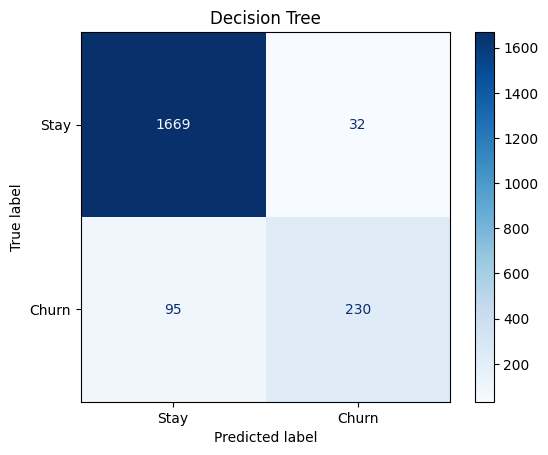

In [8]:
evaluate(best_tree, "Decision Tree", "decision_tree_confusion_matrix")


Random Forest
Accuracy : 0.958
Precision: 0.951
Recall   : 0.775
F1-score : 0.854
ROC-AUC  : 0.991


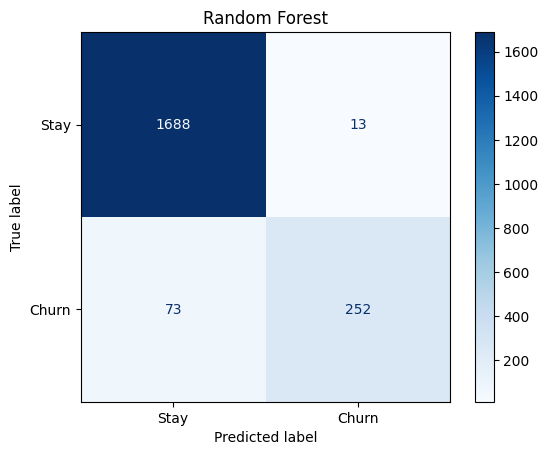

In [9]:
evaluate(best_forest, "Random Forest", "random_forest_default_confusion_matrix")

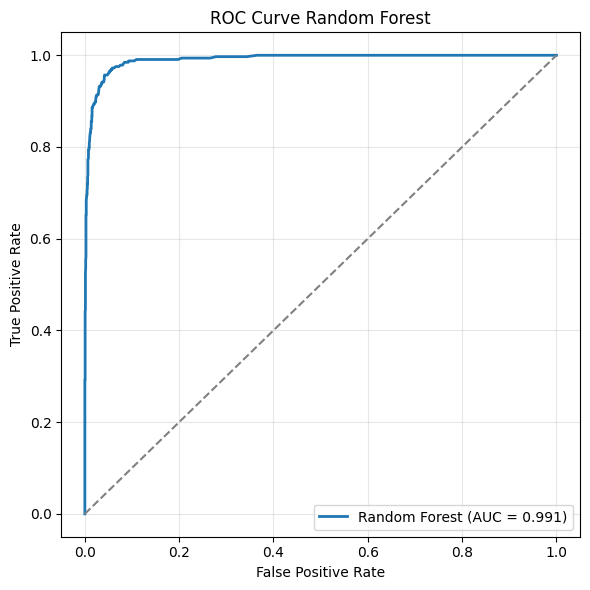

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = best_forest.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_val = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_val:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("img/trees/roc_curve_random_forest.png", dpi=300)
plt.show()

As you can see, we've achieved a quite good performance with both models. <br>
As expected, the random forest classifier performs better than the decision tree classifier. <br>

However, in the confusion matrix, the number of falsely predicted to stay (who really churned) is lower than the number of falsely predicted to churn (aka recall < precision). Is that better or not depends on the end-goal. <br>

Since we are interested in determining and doing something with people who are about to churn (giving them some benefits etc.), in my opinion, recall is more important to us. <br>
Because predicting that the churn-client stays (=> we lose a client) is worse than predicting that the stay-client churns (=> we lose the extra benefists given). <br>

This is why I want to tweak the threshold to increase the recall. <br>
We can do this by considering the threshold that maximizes the F2 score, which prioritizes recall over precision. <br>
While looking for the best F-beta score you can change the beta as you like, depending on how much a lost client is worth to you. I chose `beta = 2` <br>

Best threshold (max-F2): 0.215
Accuracy : 0.958
Precision: 0.814
Recall   : 0.957
F1-score : 0.880
F2-score : 0.924


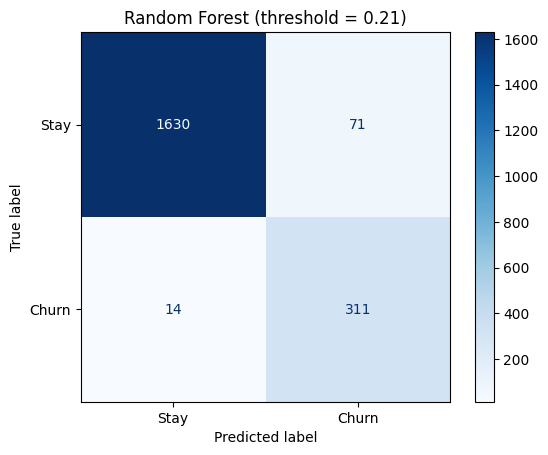

In [11]:
y_prob = best_forest.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_prob)
beta = 2
f2 = (1 + beta**2) * prec[:-1] * rec[:-1] / (beta**2 * prec[:-1] + rec[:-1])

best_thr = thr[int(np.argmax(f2))]

y_pred_opt = (y_prob >= best_thr).astype(int)
print(f"Best threshold (max-F{beta}): {best_thr:.3f}")
print(f"Accuracy : {accuracy_score(y_test, y_pred_opt):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_opt):.3f}")
print(f"F1-score : {f1_score(y_test, y_pred_opt):.3f}")
print(f"F{beta}-score : {fbeta_score(y_test, y_pred_opt, beta=beta):.3f}")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_opt, display_labels=["Stay", "Churn"], cmap="Blues"
)
plt.title(f"Random Forest (threshold = {best_thr:.2f})")
plt.savefig("img/trees/random_forest_better_confusion_matrix", dpi=300)
plt.show()

This model looks better than the one with the 0.5 threshold: we misclassified only 14 churning clients as staying.

## Interpretability
Now lets visualize the decision tree for interpretability.

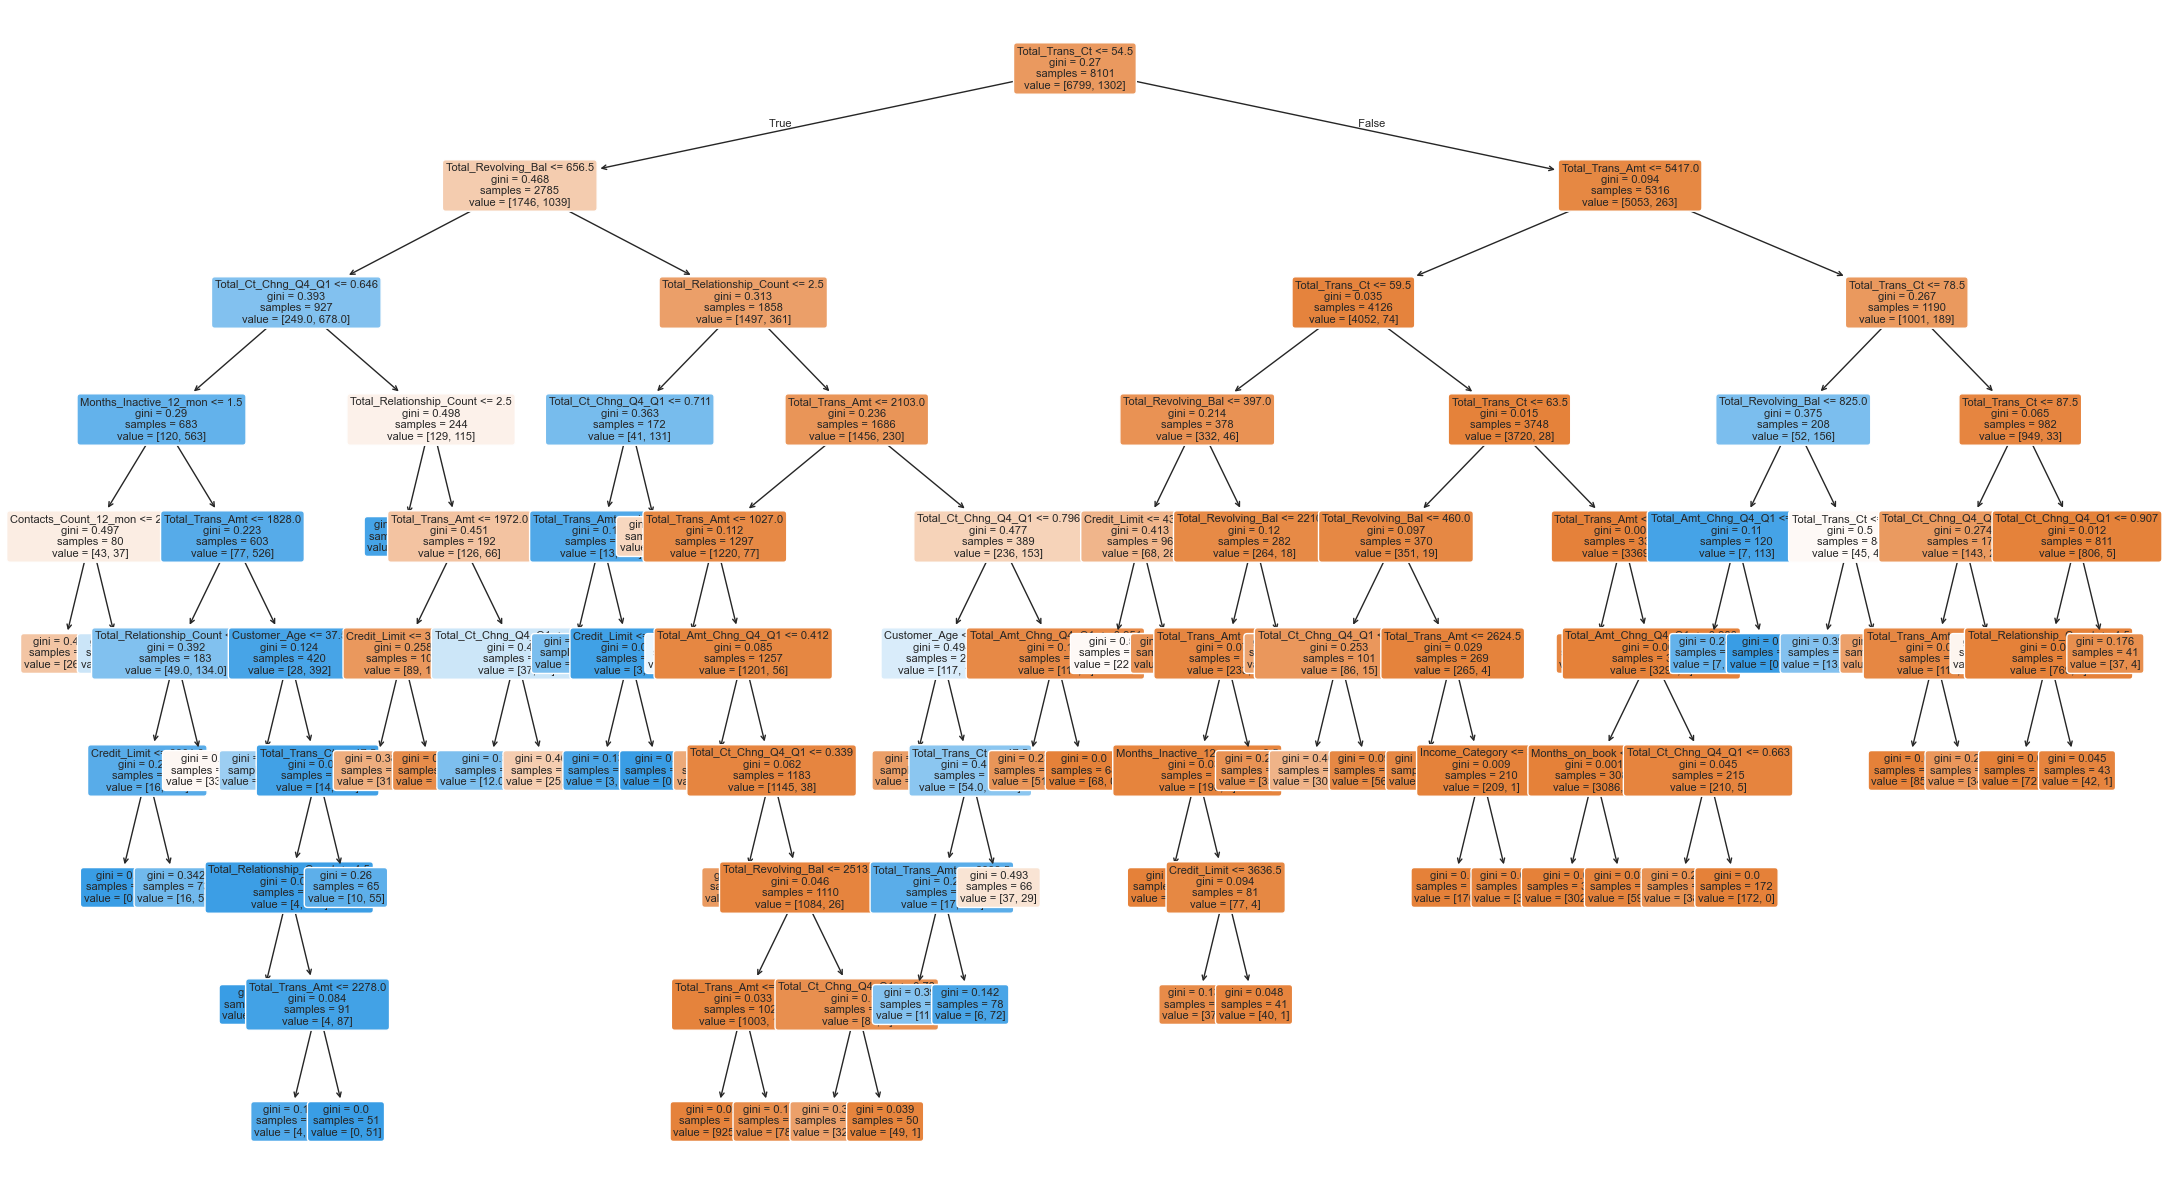

In [12]:
from sklearn.tree import plot_tree

forest_clf = best_forest.named_steps["model"]
ohe_cols = best_forest.named_steps["prep"].transformers_[1][1].get_feature_names_out(categorical_nominal)
ord_cols = categorical_ordinal
feature_names = numeric_cols + list(ohe_cols) + ord_cols

plt.figure(figsize=(22, 12))
plot_tree(
    best_tree.named_steps["model"],
    feature_names=feature_names,
    filled=True,
    rounded=True,
    proportion=False,
    fontsize=8
)
plt.tight_layout()
plt.savefig("img/trees/decision_tree.png", dpi=300)
plt.show()

In the tree above, blue nodes represent customers who are likely to leave, while orange nodes represent customers who are likely to stay. <br>

Seems like Total Transactions Count is the most important feature for the decision tree classifier. <br>
Lets confirm that by looking closer at the most important features of the random forest classifier.

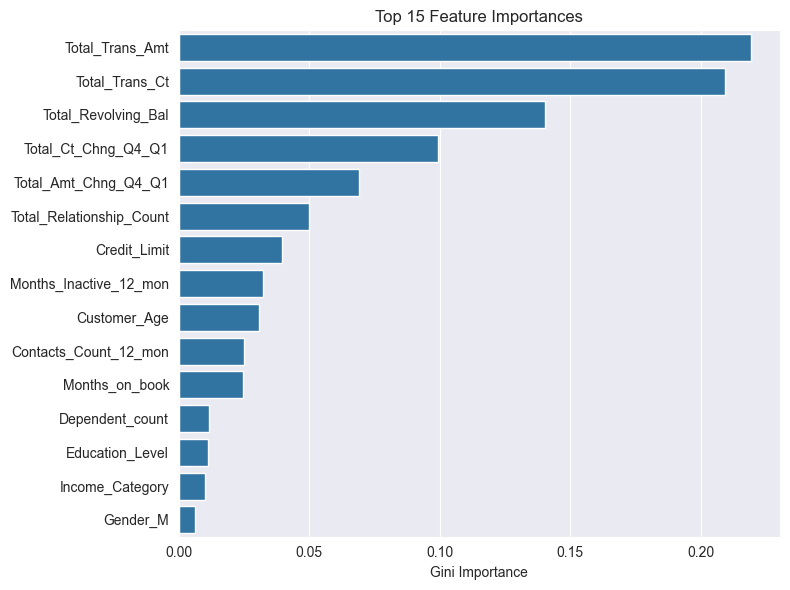

In [13]:
importances = pd.Series(forest_clf.feature_importances_, index=feature_names)
top_k = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_k.values, y=top_k.index)
plt.title("Top 15 Feature Importances")
plt.xlabel("Gini Importance")
plt.ylabel("")
plt.tight_layout()
plt.savefig("img/trees/feature_importances.png", dpi=300)
plt.show()

Higher transaction count or amount may lead to less probability of churning. <br>
In other words, customers who use the card a lot are engaged and they almost never leave. Low amount of transactions is an early-warning signal. <br>

Also those who started using the card more frequently in Q4 or have a high credit limit are maybe less likely to churn. <br>

These Gini importances don't necessary mean that the model depends on, for example, Total Transactions Amount, monotonic (higher => less churn). Maybe there are just certain spots within spending where churn rate is lower. <br>
So lets check these claims.

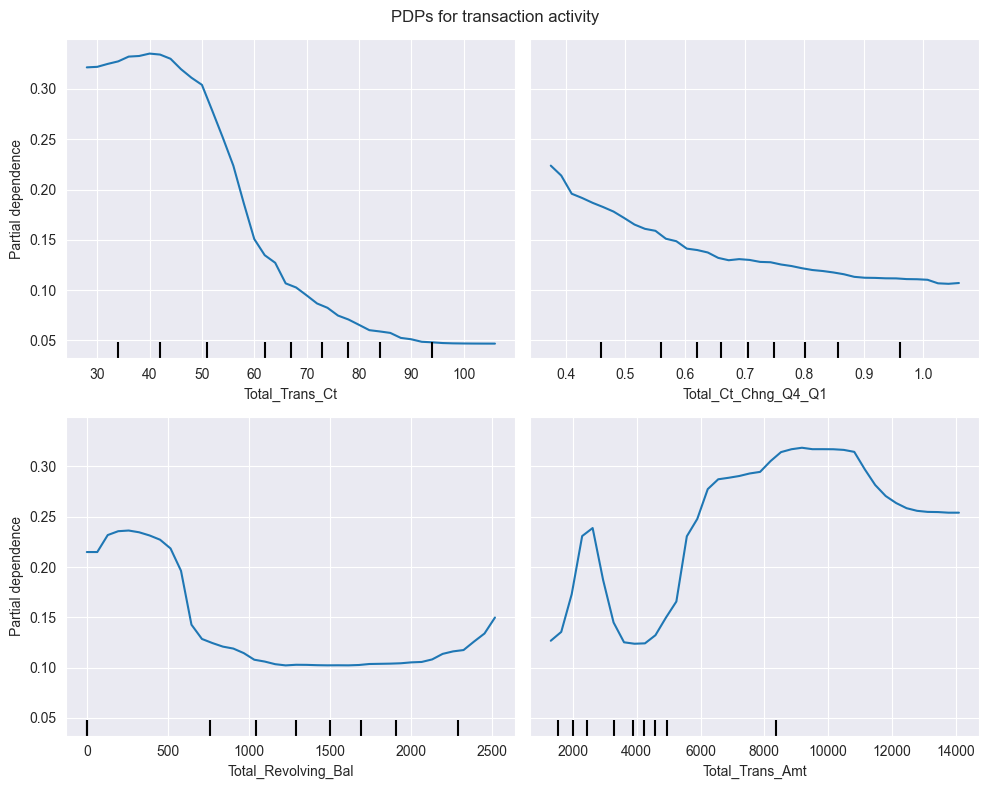

In [14]:
import warnings
from sklearn.inspection import PartialDependenceDisplay

warnings.filterwarnings("ignore", category=FutureWarning)

df["Churn"] = (df["Attrition_Flag"] == "Attrited Customer").astype(int)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
PartialDependenceDisplay.from_estimator(
    best_forest, X_test,
    ["Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Total_Revolving_Bal", "Total_Trans_Amt"],
    ax=ax, grid_resolution=40
)
fig.suptitle("PDPs for transaction activity")
plt.tight_layout()
plt.savefig("img/trees/churn_PDPs.png", dpi=300)
plt.show()

Now it is definitely true that the more transactions you have, the less likely you are to churn. <br>

The same applies to the `Total_Ct_chng_Q4_Q1` feature, which is the change in the number of transactions in Q4 compared to Q1. <br>

Total revolving balance is a bit trickier. Low balance means high churn rate, then there's a steep drop to a plateau, and in the very end it starts to rise a bit again. It's worth noting that the highest amount of balance in the dataset is 2517, and as many as 508 people have it, which is odd. Maybe the data was clipped or there has been an error in the data collection process. This has to be confirmed and until then the rise and the end of the plot is not reliable. <br>

The total transaction amount plot is also non-monotonic. The data shows that the most loyal customers are those who spend a moderate amount of money, between 3000 and 5000. <br>
People who spend nothing may have just gotten the card, which explains the low partial dependence value in the beginning of the plot. The probability also goes down for those who spend more than 12000. <br>

Now lets also check the permutation importance of the features.

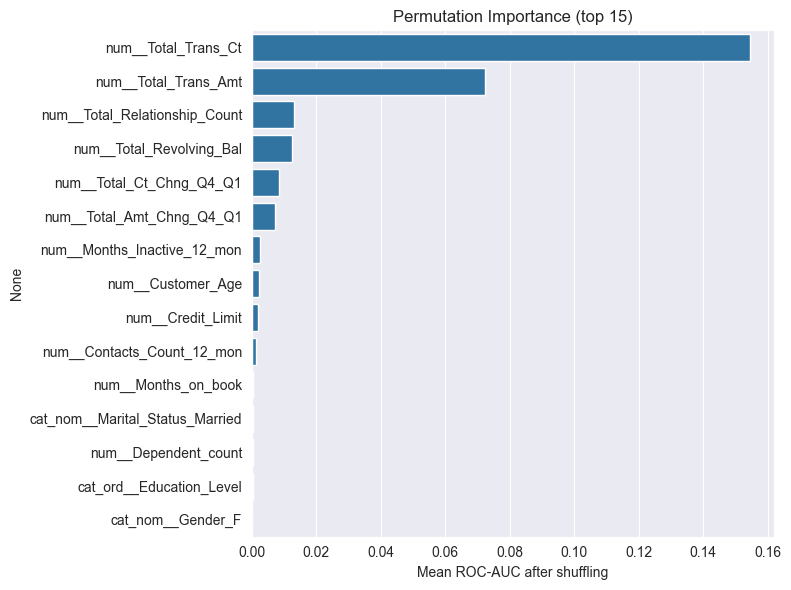

In [15]:
from sklearn.inspection import permutation_importance

prep = best_forest.named_steps["prep"]
forest = best_forest.named_steps["model"]

X_test_enc = prep.transform(X_test)
encoded_feature_names = prep.get_feature_names_out()

perm = permutation_importance(forest, X_test_enc, y_test, n_repeats=50, random_state=239, scoring="roc_auc")

importances = pd.Series(perm.importances_mean, index=encoded_feature_names)
top = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top.values, y=top.index)
plt.title("Permutation Importance (top 15)")
plt.xlabel("Mean ROC-AUC after shuffling")
plt.tight_layout()
plt.savefig("img/trees/permutation_importances.png", dpi=300)
plt.show()

This shows basically the same picture as the Gini importance plot. <br>
The most important features are Total Transactions Count and Amount.

We can visualize these separately to see how they are correlated with churn. <br>

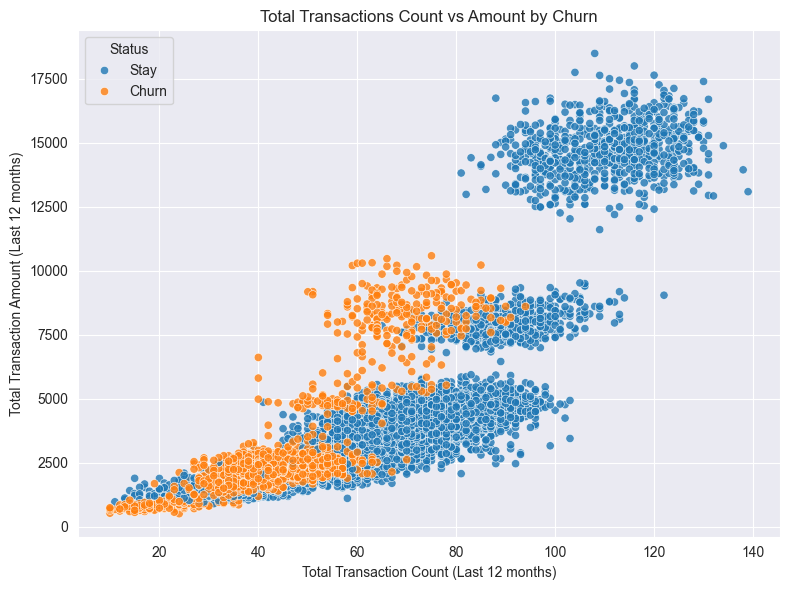

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Total_Trans_Ct",
    y="Total_Trans_Amt",
    hue="Churn",
    alpha=0.8
)
plt.title("Total Transactions Count vs Amount by Churn")
plt.xlabel("Total Transaction Count (Last 12 months)")
plt.ylabel("Total Transaction Amount (Last 12 months)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["Stay", "Churn"], title="Status")
plt.tight_layout()
plt.savefig("img/trees/transactions_scatter_churn.png", dpi=300)
plt.show()

First, the plot looks familiar, because it is similar to the PCA plot. This is because the first two principal components are linear combinations of the features, and those two features are the most important ones. <br>

In the plot is it very clear that the cluster of clients with >80 transactions and >12000 amount is the most loyal. <br>
The cluster of medium-amount clients clearly shows that the amount of the transactions is very important (more tx => less churn). <br>
The lowest-amount cluster also depicts the `higher => less churn` tendency. <br>

No wonder the classifier is so good at predicting churn, because the data is very informative even with two features. <br>

Now lets also look at how the churn rate is correlated with out categorical features and analyze the results. <br>

In [17]:
def churn_rate_by_feature(feature_name):
    pct = pd.crosstab(df[feature_name], df["Attrition_Flag"], normalize="index") * 100
    edu_churn_pct = pct.sort_values("Attrited Customer", ascending=False)

    plt.figure(figsize=(7, 4))
    sns.barplot(x=edu_churn_pct.index, y=edu_churn_pct["Attrited Customer"], palette="Blues_r")
    plt.ylabel("Churn rate (%)")
    plt.xlabel(feature_name)
    plt.title(f"Churn rate by {feature_name}")
    plt.tight_layout()
    plt.savefig(f"img/trees/categorical/{feature_name}_churn.png", dpi=300)
    plt.show()

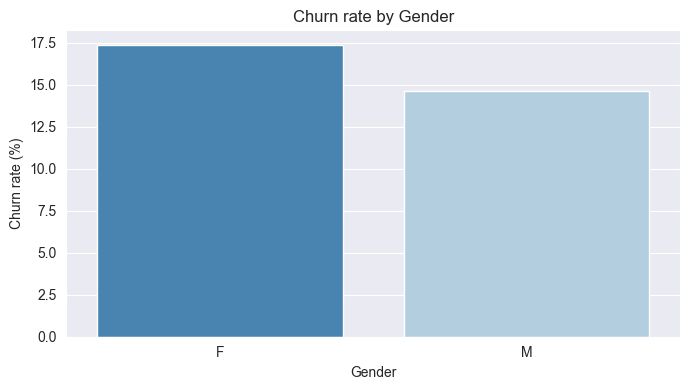

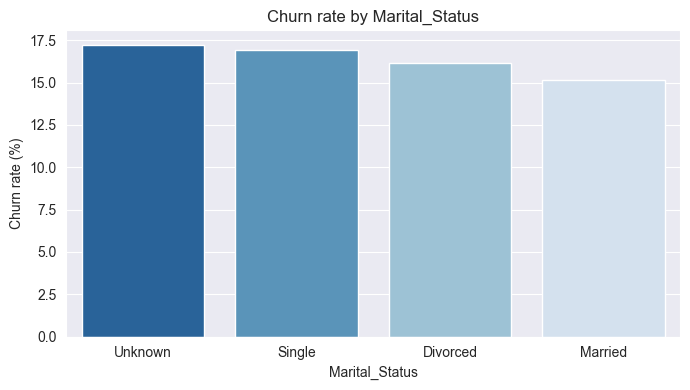

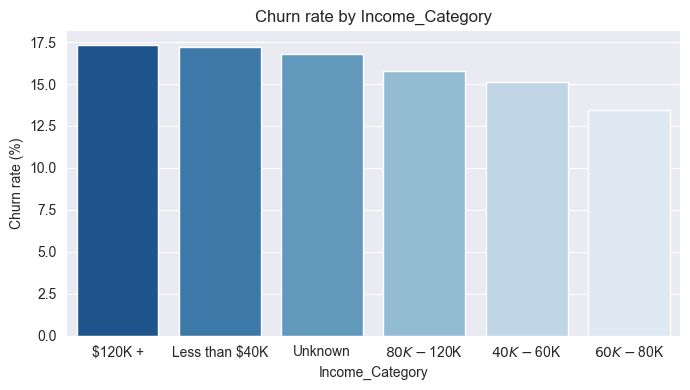

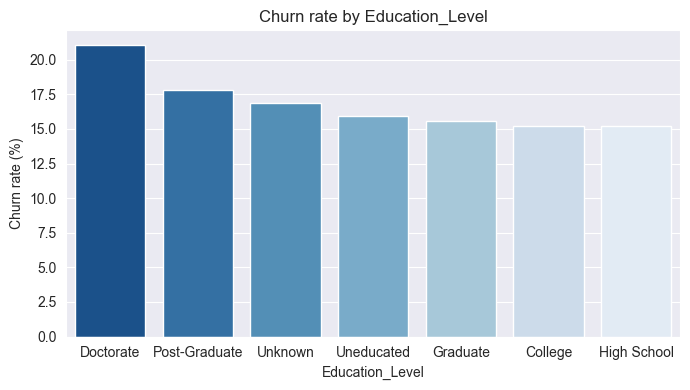

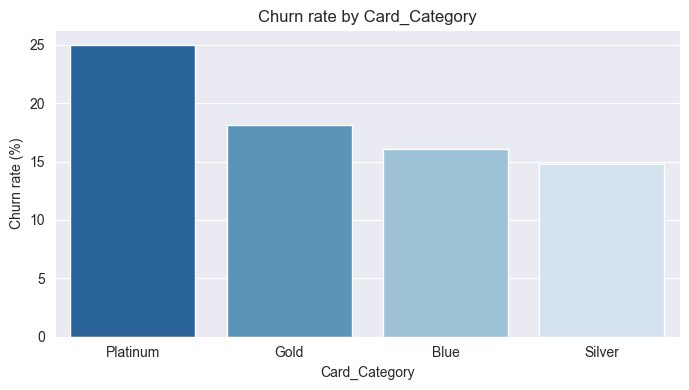

In [18]:
for feature in categorical_nominal + categorical_ordinal:
    churn_rate_by_feature(feature)

1. Women are more likely to churn, but the difference is not that big. <br>
2. Married clients are less likely to churn, which is logical, since they have a more stable financial situation. <br>
3. The results are quite mixed here, no wonder `Income_Category` is not one of the most import features in the model. <br>
4. The plot shows that clients with higher education are more likely to churn. In other words, doctors are smart and prefer using debit cards (as you should from a personal finance perspective). But not from the bank perspective, so the bank should think about how to retain those clients (maybe by providing some features that this group needs).
5. Platinum card holders are less loyal, which is surprising. However, those are only 20 people in the dataset so the results are not reliable. <br>